<a href="https://colab.research.google.com/github/devamsheth21/Railway-Track-Defect-Detection/blob/main/railtrack_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 7.3MB/s 


In [ ]:
train_dir = '/content/gdrive/MyDrive/Untitled Folder/Railway Track fault Detection Updated/Train'
val_dir   = '/content/gdrive/MyDrive/Untitled Folder/Railway Track fault Detection Updated/Test'
test_dir  = '/content/gdrive/MyDrive/Untitled Folder/Railway Track fault Detection Updated/Validation'
extra_dir = '/content/gdrive/MyDrive/Untitled Folder/Railway Track fault Detection Updated/Extra'

In [ ]:
import os
train_defective_fnames = os.listdir(train_dir+'/Defective' )
train_nondefective_fnames = os.listdir(train_dir+'/Non defective')

## Show Dataset Images

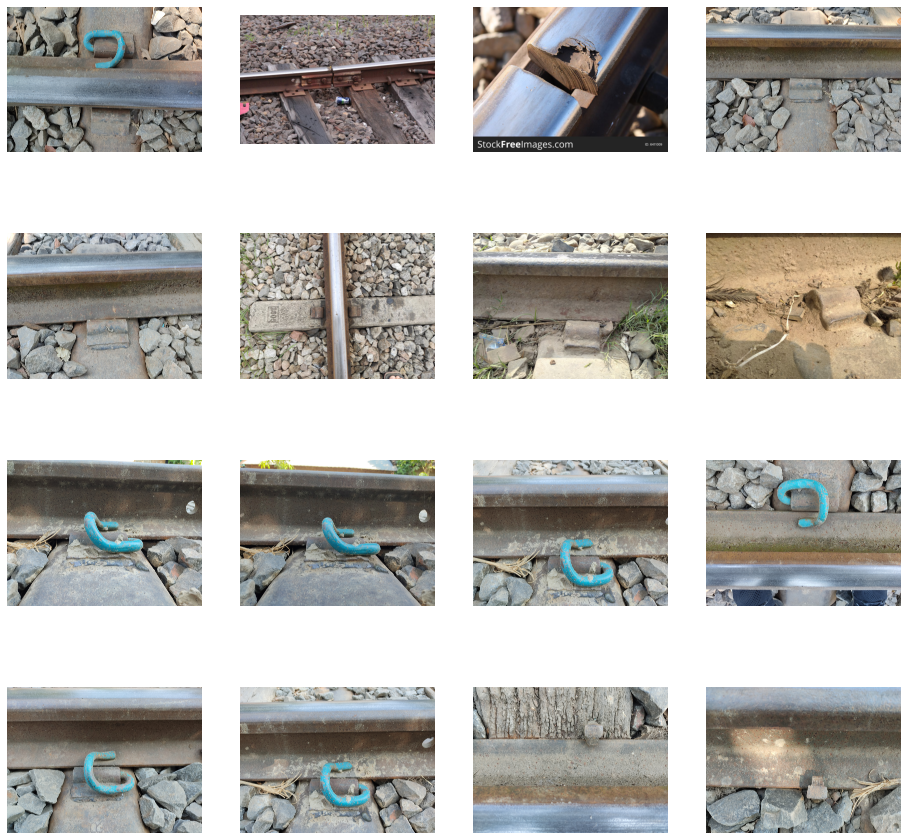

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_dir+'/Defective', fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_dir+'/Non defective', fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size=(300,300)
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 299 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 22 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,     
    class_mode=None)

Found 62 images belonging to 2 classes.


In [ ]:
extra_datagen = ImageDataGenerator(rescale=1./255)

extra_generator = extra_datagen.flow_from_directory(
    extra_dir,
    target_size=target_size,
    batch_size=1,
    color_mode='rgb',
    shuffle=False,     
    class_mode=None)

Found 2 images belonging to 2 classes.


## Build Model (EfficienetNet)

In [ ]:
num_classes = 5
input_shape = (300,300,3)

In [ ]:
import efficientnet.tfkeras as efn
from tensorflow.keras import models, layers, optimizers, regularizers, callbacks

base_model = efn.EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)
base_model.trainable = False # (transfer learning)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128)(x)
out = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=out)

model.summary()

258441216/258434480 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 64) 0           stem_bn[0][0]                    
___________________________

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
## set Checkpoint : save best only, verbose on
#checkpoint = callbacks.ModelCheckpoint("railtrack_enetB7.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

## Train Model

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL  =val_generator.n//val_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 2

In [ ]:
# Train Model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs, validation_data=val_generator, validation_steps=STEP_SIZE_VAL) #, callbacks=[checkpoint])

Epoch 1/2
18/18 [==============================] - 279s 13s/step - loss: 0.9615 - accuracy: 0.5772 - val_loss: 0.6978 - val_accuracy: 0.7500
Epoch 2/2
18/18 [==============================] - 68s 4s/step - loss: 0.6413 - accuracy: 0.7339 - val_loss: 0.6218 - val_accuracy: 0.7500


## Save Model

In [ ]:
models.save_model(model, 'saved_model.h5')

In [ ]:
#model.load_weights("model name here")

## Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

predY=model.predict(test_generator) 
y_pred = np.argmax(predY,axis=1)
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[28  3]
 [ 6 25]]


In [ ]:

labels = ['Defective', 'Non Defective']
print(classification_report(y_actual, y_pred, target_names=labels))

               precision    recall  f1-score   support

    Defective       0.82      0.90      0.86        31
Non Defective       0.89      0.81      0.85        31

     accuracy                           0.85        62
    macro avg       0.86      0.85      0.85        62
 weighted avg       0.86      0.85      0.85        62



## Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


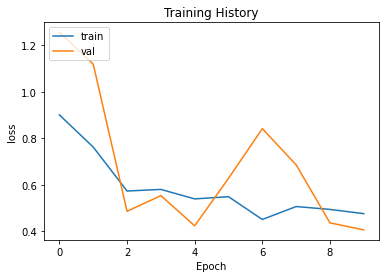

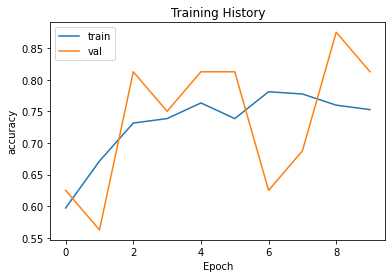

In [ ]:
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

# Testing our model on random images

In [ ]:
predz=model.predict(extra_generator)
z_pred = np.argmax(predz,axis=1)
print(z_pred)
print(predz)

[0 1]
[[0.95986164 0.04013842]
 [0.01798638 0.98201364]]
